# Recipe Recommender System Model

This notebook presents the python code used to build a recipe recommender system based on BPR.

In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline

In [2]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [3]:
def getAllUsersWithReviews(start_path, files):
    users = set()
    for file in files:
        try:
            with open(start_path + file + "/reviews.json") as data_file:    
                reviews = json.load(data_file)
                for review in reviews:
                    users.add(review["submitter"]["userID"])
        except: 
            print("Problem with file: " + file)
    return users

In [9]:
users = getAllUsersWithReviews("recipe_data/", recipes)

In [10]:
len(users)

1017178

In [11]:
userRecipes = {}
recipeUsers = {}

for user in users:
    userRecipes[user] = []

for recipe in recipes:
    recipeUsers[recipe] = []

for recipe in recipes:
    with open("recipe_data/" + recipe + "/reviews.json") as data_file:
        reviews = json.load(data_file)
        for review in reviews:
            user = review["submitter"]["userID"]
            userRecipes[user].append(recipe)
            recipeUsers[recipe].append(user)

In [12]:
with open("data/userRecipes.json", "w") as file:
    file.write(json.dumps(userRecipes))

with open("data/recipeUsers.json", "w") as file:
    file.write(json.dumps(recipeUsers))

In [3]:
with open("data/userRecipes.json", "r") as file:
    userRecipes = json.loads(file.read())

with open("data/recipeUsers.json", "r") as file:
    recipeUsers = json.loads(file.read())

In [4]:
users = list(userRecipes.keys())
recipes = list(recipeUsers.keys())

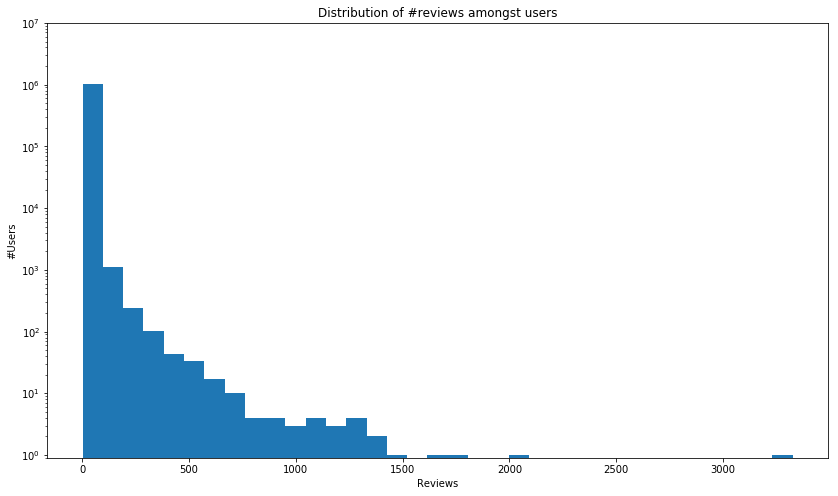

In [5]:
userDistrib = list(map(lambda x: len(userRecipes[x]), users))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(userDistrib, bins=35,log=True)
pl.title('Distribution of #reviews amongst users')
pl.xlabel('Reviews')
pl.ylabel('#Users')
font = {'family' : 'sans-serif',
        'size'   : 16}

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

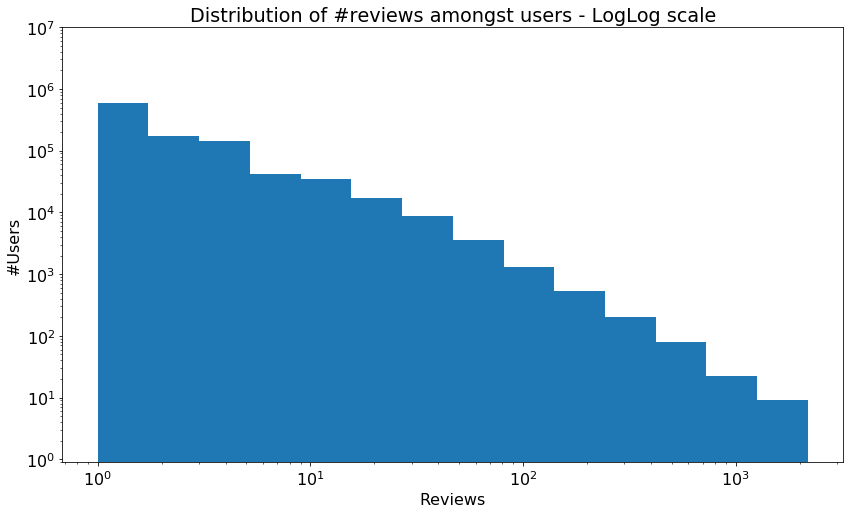

In [6]:
plt.hist(userDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.title('Distribution of #reviews amongst users - LogLog scale')
pl.xlabel('Reviews')
pl.ylabel('#Users')

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

In [7]:
pdUserDistrib = pd.DataFrame(userDistrib)
pdUserDistrib.columns = ["nb reviews"]
pdUserDistrib.describe()

,nb reviews
count,1.017178e+06
mean,3.306215e+00
std,1.245852e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.327000e+03


In [8]:
for i in [3, 5, 10, 20, 50, 100]:
    print(str(len(pdUserDistrib[pdUserDistrib["nb reviews"] >= i])) + " users with at least than " + str(i) + " reviews")

249586 users with at least than 3 reviews
135320 users with at least than 5 reviews
58247 users with at least than 10 reviews
22805 users with at least than 20 reviews
5104 users with at least than 50 reviews
1523 users with at least than 100 reviews


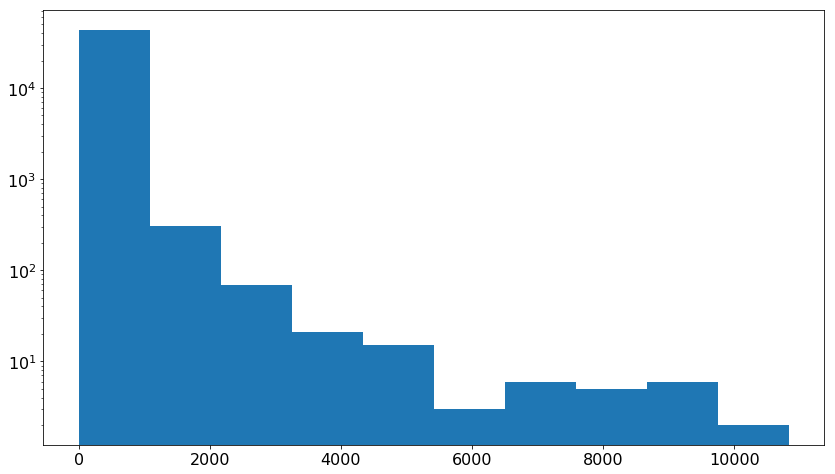

In [9]:
recipeDistrib = list(map(lambda x: len(recipeUsers[x]), recipes))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(recipeDistrib,  log=True)
plt.show()

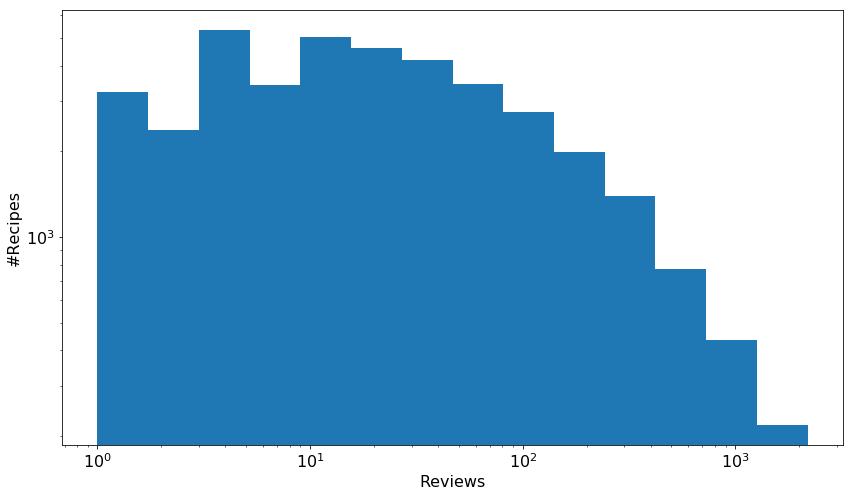

In [10]:
plt.hist(recipeDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.xlabel('Reviews')
pl.ylabel('#Recipes')

axes = plt.gca()
matplotlib.rc('font', **font)
plt.show()

In [11]:
pdrecipeDistrib = pd.DataFrame(recipeDistrib)
pdrecipeDistrib.columns = ["nb reviews"]
pdrecipeDistrib.describe()

,nb reviews
count,44069.000000
mean,76.312351
std,293.079980
min,0.000000
25%,3.000000
50%,12.000000
75%,47.000000
max,10835.000000


## Cleaning data


In [12]:
cleanedUserRecipes = {}
cleanedRecipeUsers = {}

for user, recipes in userRecipes.items():
    if len(recipes) >= 10 and len(recipes) < 200:
        cleanedUserRecipes[user] = recipes
        for recipe in recipes:
            if recipe in cleanedRecipeUsers.keys():
                cleanedRecipeUsers[recipe].extend([user])
            else:
                cleanedRecipeUsers[recipe] = [user]
        


In [13]:
def cleanSmall(UserRecipes, RecipeUsers, threshold):
    
    cleaned = False
    while cleaned == False:
    
        nbUsers = len(UserRecipes.keys())
        nbRecipes = len(RecipeUsers.keys())

        print("Cleaning users and recipes with less than " + str(threshold) + " reviews")
        print("Number of users: "  + str(nbUsers))
        print("Number of recipes: "  + str(nbRecipes))

        toRemove = []
        for recipe, users in RecipeUsers.items():
            if len(users) < threshold:
                toRemove.extend([recipe])

        for recipe in toRemove:
            RecipeUsers.pop(recipe)

        UserRecipes = {}
        for recipe, users in RecipeUsers.items():
            for user in users:
                if user in UserRecipes.keys():
                    UserRecipes[user].extend([recipe])
                else:
                    UserRecipes[user] = [recipe]

        toRemove= []
        for user, recipes in UserRecipes.items():
            if len(recipes) < threshold:
                toRemove.extend([user])

        for user in toRemove:
            UserRecipes.pop(user) 

        RecipeUsers = {}
        for user, recipes in UserRecipes.items():
            for recipe in recipes:
                if recipe in RecipeUsers.keys():
                    RecipeUsers[recipe].extend([user])
                else:
                    RecipeUsers[recipe] = [user]   

        if len(UserRecipes.keys()) == nbUsers and len(RecipeUsers.keys()) == nbRecipes:
            cleaned = True
    return UserRecipes, RecipeUsers

In [14]:
userRecipes, recipeUsers = cleanSmall(cleanedUserRecipes, cleanedRecipeUsers, 10)

Cleaning users and recipes with less than 10 reviews
Number of users: 57802
Number of recipes: 32986
Cleaning users and recipes with less than 10 reviews
Number of users: 54716
Number of recipes: 15120
Cleaning users and recipes with less than 10 reviews
Number of users: 54590
Number of recipes: 14864
Cleaning users and recipes with less than 10 reviews
Number of users: 54584
Number of recipes: 14854


In [15]:
users = list(userRecipes.keys())
recipes = list(recipeUsers.keys())

In [16]:
min(map(lambda x: len(recipeUsers[x]), recipeUsers.keys()))

10

In [17]:
min(map(lambda x: len(userRecipes[x]), userRecipes.keys()))

10

In [18]:
nbUsers = len(userRecipes.keys())
nbRecipes = len(recipeUsers.keys())
print("Number of users: "  + str(nbUsers))
print("Number of recipes: "  + str(nbRecipes))

Number of users: 54584
Number of recipes: 14854


In [19]:
len(recipes)

14854

## Building Model

In [20]:
'''# Sample 1000 recipes and 10000 users for test
N = 1000
M = 10000

sampleRecipes = np.random.choice(list(recipes), N)
sampleUsers = []
while len(sampleUsers) < M:
    r = np.random.choice(sampleRecipes)
    if(len(recipeUsers[r]) > 1):
        u = np.random.choice(recipeUsers[r])
        if str(u) not in sampleUsers:
            sampleUsers.append(str(u))
            '''

'# Sample 1000 recipes and 10000 users for test\nN = 1000\nM = 10000\n\nsampleRecipes = np.random.choice(list(recipes), N)\nsampleUsers = []\nwhile len(sampleUsers) < M:\n    r = np.random.choice(sampleRecipes)\n    if(len(recipeUsers[r]) > 1):\n        u = np.random.choice(recipeUsers[r])\n        if str(u) not in sampleUsers:\n            sampleUsers.append(str(u))\n            '

In [21]:
  '''W = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        if sampleRecipes[i] in userRecipes[sampleUsers[j]]:
            W[i,j] = 1  '''

'W = np.zeros((N,M))\nfor i in range(N):\n  for j in range(M):\n      if sampleRecipes[i] in userRecipes[sampleUsers[j]]:\n          W[i,j] = 1  '

In [22]:
  '''sampleInteractions = []

for user in sampleUsers:
    for recipe in sampleRecipes:
        if recipe in userRecipes[user]:
            sampleInteractions.append((recipe, user))  '''

'sampleInteractions = []\n\nfor user in sampleUsers:\n  for recipe in sampleRecipes:\n      if recipe in userRecipes[user]:\n          sampleInteractions.append((recipe, user))  '

In [23]:
interactions = []
for user in users:
    for recipe in userRecipes[user]:
        interactions.append((recipe, user))

#interactions = np.array(sampleInteractions)

## Use sample instead of real values


In [24]:
'''recipes = sampleRecipes
users = sampleUsers
interactions = sampleInteractions  '''

'recipes = sampleRecipes\nusers = sampleUsers\ninteractions = sampleInteractions  '

## Model

In [25]:
userDict = {}
for i in range(len(users)):
    userDict[users[i]] = i
    
recipeDict = {}
for i in range(len(recipes)):
    recipeDict[recipes[i]] = i

In [26]:
def sample_neg(recipes, user, userRecipes):
    recipe  = recipes[np.random.randint(0, len(recipes))]
    while recipe in userRecipes[user]:
        recipe  = recipes[np.random.randint(0, len(recipes))]
    return recipe

In [27]:
# Split test-train 

userRecipes_tr = {}
for interaction in interactions:
    r = interaction[0]
    u = interaction[1]
    if u not in userRecipes_tr.keys():
        userRecipes_tr[u] = [r]
    else:
        userRecipes_tr[u].append(r)

interactions_te = []
userRecipes_te = {}
for user in userRecipes_tr.keys():
    test_recipe = np.random.choice(userRecipes_tr[user])
    userRecipes_tr[user].remove(test_recipe)
    userRecipes_te[user] = test_recipe
    interactions_te.append((test_recipe, user))

interactions_tr = []
for user in userRecipes_tr.keys():
    for recipe in userRecipes_tr[user]:
        interactions_tr.append((recipe, user))

### Weight interactions inversely to popularity

In [150]:
# Returns an array with interactions replicated according to the inverse frequency of the recipe
# An interaction with the most popular recipe will be present only once in the array.
# This way, selecting a random interaction in the array will select recipes uniformly
def probWeightedInteractions(interactions, recipeUsers, power = 0):
    apps = np.zeros((len(interactions)))
    for i in range(len(interactions)):
        apps[i] = (len(recipeUsers[interactions[i][0]]))
    factor = max(apps)**(1 - power)
    weighted_inter =np.zeros((len(interactions)))
    for i in range(len(apps)):
        weighted_inter[i] = 1 / apps[i] * (apps[i]**power) * factor
        
    interactions_array = []
    for i in range(int(len(interactions))):
        for j in range(int(round(weighted_inter[i]))):
            interactions_array.append(interactions[i])
    return interactions_array

Let's check the effect of the method

In [134]:
from collections import Counter

def plotInteractionDistrib(interactions_list, legends = None):
    for i in range(len(interactions_list)): 
        interactions = interactions_list[i]
        recipes = list(map(lambda x: x[0], interactions))
        c = Counter(recipes)
        count = list(map(lambda x: c[x], c.keys()))
        count = sorted(count)
        if legends:
            plt.plot(count, label="x = " + str(legends[i]))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.plot(count)
    plt.show()

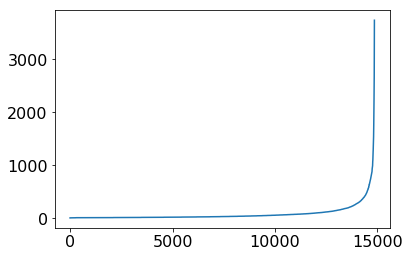

In [135]:
plotInteractionDistrib([interactions_tr])

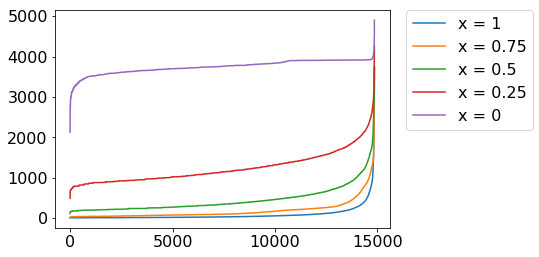

In [154]:
powers = [1, 3/4, 1/2, 1/4, 0]
plotInteractionDistrib(list(map(lambda x: probWeightedInteractions(interactions_tr, recipeUsers, x), powers)), powers)

In [151]:
test = probWeightedInteractions(interactions_tr, recipeUsers, 1)

In [152]:
len(test)

1224997

In [153]:
len(interactions_tr)

1224997

## Run Bayesian Personalized Ranking

In [76]:
def BPR(interactions_tr, interactions_te, bias, alpha = 0.01, K = 30, P = None, Q = None, prob = False):
        
    print("BPR with K: " + str(K))
    aucs = []

    _iter = 25*10**6; # number of iterations
    _lambda = 0.01; # regularizer

    # Initialize low-rank matrices with random values
    if P is None or Q is None:
        sigma = 0.1; # std for random initialization
        mu = 0.0; # mean for random initialization
        N = len(users)
        M = len(recipes)
        P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
        Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes
    
    b = np.zeros(len(recipes))
    
    if(prob):
        interactions_tr = probWeightedInteractions(interactions_tr, recipeUsers)
        print("done")

    for step in range(_iter + 1):

        # Select a random positive example
        i  = interactions_tr[np.random.randint(0, len(interactions_tr))]
        recipe = i[0]
        user = i[1]
        ir = recipeDict[recipe]
        iu = userDict[user]

        # Sample a negative example
        ji = recipeDict[sample_neg(recipes, user, userRecipes_tr)]

        # See BPR paper for details
        px = np.dot(P[iu,:], (Q[:,ir]-Q[:,ji]))
        if bias:
            px += (b[ir]-b[ji]) 
        z = 1 / (1 + np.exp(px))

        # update P
        d = (Q[:,ir]-Q[:,ji])*z - _lambda*P[iu,:].T
        P[iu,:] = P[iu,:] + alpha*d.T

        # update Q positive 
        d = P[iu,:]*z - _lambda*Q[:,ir].T
        Q[:,ir] = Q[:,ir] + alpha*d.T

        # update Q negative
        d = -P[iu,:]*z - _lambda*Q[:,ji].T
        Q[:,ji] = Q[:,ji] + alpha*d.T

        if bias:
            # neg
            d = -z - _lambda*b[ji]
            b[ji] = b[ji] + alpha*d

            # pos
            d = z - _lambda*b[ir]
            b[ir] = b[ir] + alpha*d

        if step % 500000 == 0:
            print("Computing AUC...")
            # Compute the Area Under the Curve (AUC)
            auc = 0;
            for interaction in interactions_te:
                recipe = interaction[0]
                user = interaction[1]
                n_recipe = sample_neg(recipes, user, userRecipes)
                
                ir = recipeDict[recipe]
                iu = userDict[user]
                ji = recipeDict[n_recipe]

                sp = np.dot(P[iu,:],Q[:,ir])
                sn = np.dot(P[iu,:],Q[:,ji])
                
                if bias:
                    sp += b[ir]
                    sn += b[ji]

                if sp > sn:
                    auc = auc+1
                else:
                    if sp == sn:
                        auc = auc+0.5

            auc = auc / len(userRecipes_te.keys())
            print("AUC test: " + str(auc))
            aucs.append(auc)
            
    return aucs

In [ ]:
sigma = 0.1; # std for random initialization
mu = 0.0; # mean for random initialization
K = 30
N = len(users)
M = len(recipes)
P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes

In [ ]:
k_range = np.linspace(K, K, 1)
perf = []
for k in k_range:
    perf.append(BPR(interactions_tr, interactions_te, True, 0.01, int(k), P, Q, prob=False))

In [70]:
sigma = 0.1; # std for random initialization
mu = 0.0; # mean for random initialization
K = 30
N = len(users)
M = len(recipes)
P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes

In [78]:
k_range = np.linspace(K, K, 1)
perf = []
for k in k_range:
    perf.append(BPR(interactions_tr, interactions_te, False, 0.01, int(k), P, Q, prob=False))

BPR with K: 30
Computing AUC...
AUC test: 0.5164700278469881
Computing AUC...
AUC test: 0.5206653964531731
Computing AUC...
AUC test: 0.5219844643118863
Computing AUC...
AUC test: 0.5227722409497289
Computing AUC...
AUC test: 0.5247142019639455
Computing AUC...
AUC test: 0.5250622893155503
Computing AUC...
AUC test: 0.5290194928916899
Computing AUC...
AUC test: 0.5343507254873223
Computing AUC...
AUC test: 0.5390224241535981
Computing AUC...
AUC test: 0.5416055987102447
Computing AUC...
AUC test: 0.5463139381503738
Computing AUC...
AUC test: 0.559871024476037
Computing AUC...
AUC test: 0.5685915286530852
Computing AUC...
AUC test: 0.5806097024769163
Computing AUC...
AUC test: 0.5988201670819288
Computing AUC...
AUC test: 0.61212076799062
Computing AUC...
AUC test: 0.6272167668181152
Computing AUC...
AUC test: 0.6448409790414773
Computing AUC...
AUC test: 0.6629415213249303
Computing AUC...
AUC test: 0.6773230250622894
Computing AUC...
AUC test: 0.6913564414480434
Computing AUC...
AUC t

1

## Dummy Ranker

Evaluating the performance of a dummy ranker in order to compare it to the performance of our model. The dummy ranker simply rank recipes according to the number of reviews they have.

In [32]:
len(recipes)

14854

In [41]:
print("Computing AUC of dummy ranker...")
# Compute the Area Under the Curve (AUC)
auc = 0;
for interaction in interactions_te:
    recipe = interaction[0]
    user = interaction[1]
    n_recipe = sample_neg(recipes, user, userRecipes)

    sp = len(recipeUsers[recipe])
    sn = len(recipeUsers[n_recipe])

    if sp > sn:
        auc = auc+1
    else:
        if sp == sn:
            auc = auc+0.5

auc = auc / len(userRecipes_te.keys())
print("AUC test: " + str(auc))

Computing AUC of dummy ranker...
AUC test: 0.8256540378132786
